In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import fnmatch
import os
import SimpleITK as sitk
from matplotlib.patches import Rectangle

# ANNOTATIONS

The annotation file is a csv file that contains one finding per line. Each line holds the SeriesInstanceUID of the scan, the x, y, and z position of each finding in world coordinates; and the corresponding diameter in mm. The annotation file contains 1186 nodules.

The list of annotations that are not used as reference standard will be provided. Each line holds the SeriesInstanceUID of the scan, the x, y, and z position of each finding in world coordinates; and the corresponding diameter in mm. It has to be noted that findings that were annotated as nodule < 3 mm and non-nodule have no diameter measurement.

In [2]:
annotations = pd.read_csv("/home/msmith/luna16/CSVFILES/annotationFullPaths.csv")
print(annotations.shape)
annotations.head()

(1186, 6)


,seriesuid,coordX,coordY,coordZ,diameter_mm,serisuidComplete
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,/home/msmith/luna16/subset8/1.3.6.1.4.1.14519....
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,/home/msmith/luna16/subset8/1.3.6.1.4.1.14519....
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,/home/msmith/luna16/subset5/1.3.6.1.4.1.14519....
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,/home/msmith/luna16/subset2/1.3.6.1.4.1.14519....
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,/home/msmith/luna16/subset2/1.3.6.1.4.1.14519....


In [3]:
# Some Functions
def getPathSeriesuid(seriesuid):
    pattern = '*'+seriesuid+'*'
    for roots, dirs, files in os.walk('/home/msmith/luna16/'):
            for filename in fnmatch.filter(files,pattern):
                returnPath = os.path.join(roots,filename)
                #print(returnPath)
    return returnPath

def getAnnotationsFullPathCSV():
    # Includes full path of files in final column
    annotations["serisuidComplete"] = annotations["seriesuid"].apply(getPathSeriesuid) # Get complete paths of files (takes a while)
    annotations.to_csv("/CSVFILES/annotationsFullPaths.csv",index=0)

def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyImage, numpyOrigin, numpySpacing

def load_originSpacing(filename):
    itkimage = sitk.ReadImage(filename)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyOrigin, numpySpacing

'''
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    numpyOrigin = np.array(list(itkimage.GetOrigin()))
    numpySpacing = np.array(list(itkimage.GetSpacing()))
    return numpyImage, numpyOrigin, numpySpacing
'''

def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord
#ofInterest = annotations[annotations["seriesuid"].str.contains("1.3.6.1.4.1.14519.5.2.1.6279.6001.105495028985881418176186711228")]

In [4]:
def getImageNVC(obs):
    annotation = annotations.iloc[obs]
    noduleCoords = annotation['coordX'],annotation['coordY'],annotation['coordZ']
    mhdPath = annotation.serisuidComplete.replace(".raw",".mhd")
    imgOrigin, imgSpacing = load_originSpacing(mhdPath)

    nvc = worldToVoxelCoord(noduleCoords[::-1],imgOrigin,imgSpacing)
    nvc = np.array(nvc.astype(int))
    return nvc


In [5]:
# Append Vox coords to dataframe
annotations['vxX'] = pd.Series(np.zeros(annotations.shape[0]), index=annotations.index)
annotations['vxY'] = pd.Series(np.zeros(annotations.shape[0]), index=annotations.index)
annotations['vxZ'] = pd.Series(np.zeros(annotations.shape[0]), index=annotations.index)
annotations.head(10)

,seriesuid,coordX,coordY,coordZ,diameter_mm,serisuidComplete,vxX,vxY,vxZ
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471,/home/msmith/luna16/subset8/1.3.6.1.4.1.14519....,0,0,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708,/home/msmith/luna16/subset8/1.3.6.1.4.1.14519....,0,0,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,/home/msmith/luna16/subset5/1.3.6.1.4.1.14519....,0,0,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,/home/msmith/luna16/subset2/1.3.6.1.4.1.14519....,0,0,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,/home/msmith/luna16/subset2/1.3.6.1.4.1.14519....,0,0,0
5,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,90.931713,149.027266,-426.544715,18.208570,/home/msmith/luna16/subset2/1.3.6.1.4.1.14519....,0,0,0
6,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,89.540769,196.405159,-515.073322,16.381276,/home/msmith/luna16/subset2/1.3.6.1.4.1.14519....,0,0,0
7,1.3.6.1.4.1.14519.5.2.1.6279.6001.100953483028...,81.509646,54.957219,-150.346423,10.362321,/home/msmith/luna16/subset3/1.3.6.1.4.1.14519....,0,0,0
8,1.3.6.1.4.1.14519.5.2.1.6279.6001.102681962408...,105.055792,19.825260,-91.247251,21.089619,/home/msmith/luna16/subset9/1.3.6.1.4.1.14519....,0,0,0
9,1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760...,-124.834262,127.247155,-473.064479,10.465854,/home/msmith/luna16/subset1/1.3.6.1.4.1.14519....,0,0,0


In [28]:
def makeAnnotationsCSVnodules():
    for obs in xrange(annotations.shape[0]):
        #print(annotations.shape[0])
        if obs % 100 ==0:
            print(obs)
        nvc = getImageNVC(obs)

        annotations.set_value(obs, 'vxX', nvc[2])
        annotations.set_value(obs, 'vxY', nvc[1])
        annotations.set_value(obs, 'vxZ', nvc[0])
    annotations.to_csv("/home/msmith/luna16/CSVFILES/annotationsNVC.csv",index=0) # annotations with just NVC

In [31]:
annotations.ix[29]

seriesuid           1.3.6.1.4.1.14519.5.2.1.6279.6001.111258527162...
coordX                                                      -80.95186
coordY                                                       10.34288
coordZ                                                      -28.39916
diameter_mm                                                   9.45444
serisuidComplete    /home/msmith/luna16/subset5/1.3.6.1.4.1.14519....
vxX                                                               167
vxY                                                               310
vxZ                                                               229
Name: 29, dtype: object

In [34]:
# Get random annotation from list
#randInt = np.random.randint(annotations.shape[0])
randInt = 20
annotationsOld = pd.read_csv("/home/msmith/luna16/CSVFILES/annotations.csv")
randAnnotation = annotationsOld.iloc[randInt]

noduleCoords = randAnnotation['coordX'],randAnnotation['coordY'],randAnnotation['coordZ']
pattern = '*'+randAnnotation['seriesuid']+'*'

imgPath = getPathSeriesuid(pattern)
rawPath = imgPath[:-3] + 'raw'
img = np.fromfile(rawPath,dtype='int16')
with open(imgPath[:-3] + 'mhd',"r") as f:
    imgData = f.read()
    mhdPath = rawPath[:-3] + 'mhd'
    
img, imgOrigin, imgSpacing = load_itk_image(mhdPath)

def printInfo():
    print("Using observation", randInt)
    print(randAnnotation)
    print("=="*50)
    print("=="*50)
    print(imgData)
    annotationsOld[randInt:randInt+1]
printInfo()

('Using observation', 20)
seriesuid      1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259...
coordX                                                 -69.12657
coordY                                                 -80.56714
coordZ                                                 -189.8066
diameter_mm                                             8.648009
Name: 20, dtype: object
ObjectType = Image
NDims = 3
BinaryData = True
BinaryDataByteOrderMSB = False
CompressedData = False
TransformMatrix = 1 0 0 0 1 0 0 0 1
Offset = -149.697265625 -339.197265625 -303.5
CenterOfRotation = 0 0 0
AnatomicalOrientation = RAI
ElementSpacing = 0.60546875 0.60546875 1
DimSize = 512 512 259
ElementType = MET_SHORT
ElementDataFile = 1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259572521472765997306.raw



In [35]:
# Nodule voxel coordinates (nvc)
nvc = worldToVoxelCoord(noduleCoords[::-1],imgOrigin,imgSpacing)
nvc = np.array(nvc.astype(int))

#Get a range in which to subset the data
margin = 50
nvcMinus,nvcPlus = (nvc - margin).astype(int), (nvc + margin).astype(int)
def printNoduleInfo():
    print("Image shape ==>" + "\n" + str(img.shape))
    print("Nodule coordinates @"+"\n" + str(nvc))
    print("NVC margins ==>" + "\n" + str(nvcMinus) + "\n" + str(nvcPlus))
printNoduleInfo()

Image shape ==>
(259, 512, 512)
Nodule coordinates @
[113 427 133]
NVC margins ==>
[ 63 377  83]
[163 477 183]


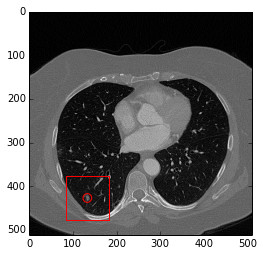

In [36]:
from matplotlib.patches import Rectangle
rectangle = plt.Rectangle((nvcMinus[2], nvcMinus[1]),margin*2 ,margin*2, facecolor = 'none', ec='r')
circle = plt.Circle((nvc[2],nvc[1]),10, facecolor = 'none', ec='r')
plt.gca().add_patch(rectangle)
plt.gca().add_patch(circle)
plt.imshow(img[nvc[0]],cmap=cm.gray)
plt.show()


63


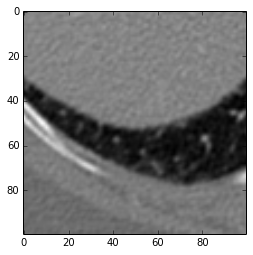

73


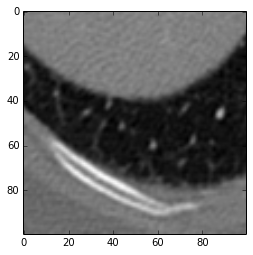

83


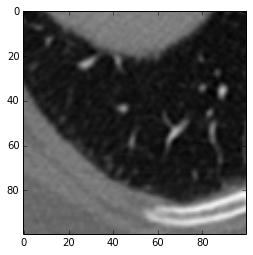

93


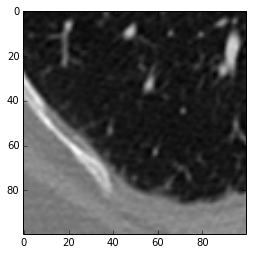

103


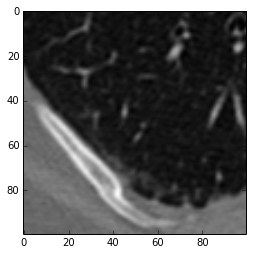

Nodule located here
113


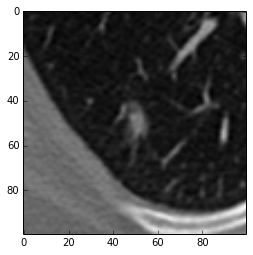

123


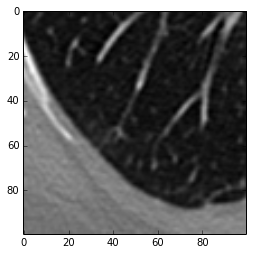

133


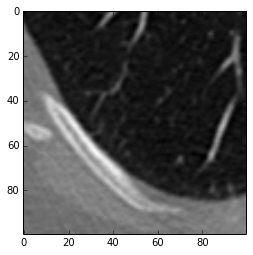

143


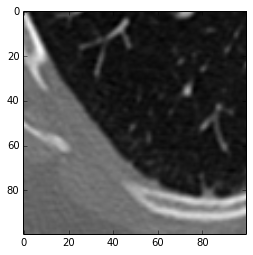

153


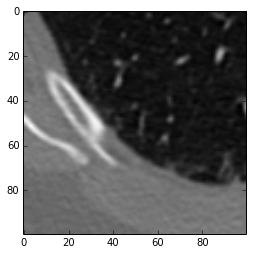

In [37]:
for i in xrange(nvcMinus[0],nvcPlus[0],10):
    if i == nvc[0]:
        print("Nodule located here")
    print(i)
    plt.imshow(img[i,nvcMinus[1]:nvcPlus[1],nvcMinus[2]:nvcPlus[2]],cmap=cm.gray)
    plt.show()

In [ ]:
voxels = img.flatten().shape[0]

In [ ]:
plt.hist(img.flatten())
plt.show()

In [ ]:
#img1 = np.clip(img[59,180:220,140:180],-1000,-600)
img1 = img[59,180:220,140:180]
plt.hist(img1.flatten())
plt.show()

In [ ]:
img2 = np.clip(img1,-1000,-800)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
x,y = np.arange(0,img1.shape[0],1),np.arange(0,img2.shape[0],1)

In [ ]:
x,y = np.meshgrid(x,y)

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,img1)

In [ ]:

x = noduleVoxelCoords[0]
y = noduleVoxelCoords[1]
z = noduleVoxelCoords[2]
for a in range(55,66,1):
    plt.figure(figsize=(7,7))
    img1=img[a,180:220,140:180]
    plt.imshow(np.clip(img1,-1000,-500),cmap=cm.gray)
    plt.show()

In [ ]:
from scipy.interpolate import RegularGridInterpolator

In [ ]:
# Get a 3D image eg. subset of img
subsetSize = 20
img3 = img[:subsetSize,:subsetSize,:subsetSize]
x,y,z = np.arange(subsetSize),np.arange(subsetSize),np.arange(subsetSize)
interpolator = RegularGridInterpolator((x,y,z),img3,bounds_error=False,fill_value=img3.mean())

In [ ]:
interpolator

# CANDIDATES

The candidates file is a csv file that contains nodule candidate per line. Each line holds the scan name, the x, y, and z position of each candidate in world coordinates, and the corresponding class. The list of candidates is provided for participants who are following the ‘false positive reduction’ track. Tutorial on how to view lesions given the location of candidates will be available on the Forum page.

The candidate locations are computed using three existing candidate detection algorithms [1-3]. As lesions can be detected by multiple candidates, those that are located <= 5 mm are merged. Using this method, 1120 out of 1186 nodules are detected with 551,065 false positives. For convenience, the corresponding class label (0 for non-nodule and 1 for nodule) for each candidate is provided in the list. It has to be noted that there can be multiple candidates per nodule.

In [ ]:
candidates = pd.read_csv("/home/msmith/luna16/CSVFILES/candidates.csv")
candidatesClass = candidates['class']
candidatesClass.hist(bins=2)
propClass1 = candidatesClass[candidatesClass==1].sum()/float(candidatesClass.size)
plt.title("Candidates class count. Proportion class 1 = "+str(propClass1))
plt.show()